It is an unexpected result for the transcriptomics to outperform the proteomics, as we would expect for the most part, proteins to be closer to phenotype and mechanism than RNA. 

Here, we hypothesize that this may be due to the fact that transcriptomics covers a larger fraction of the genome than proteomics, resulting in more comprehensive coverage, including geneds more informative of metastatic mechanisms. This may be likely for two reasons: 1) the transcriptomics didn't outperform the proteomics too strongly (by MSE effect size and no significant comparisons in Pearson), and 2) the proteomics gained its performance with a smaller subset of total features, whereas transcriptomics required all features.

In the previous notebook, we down-samples the sumple numbers of the transcriptomics as a comparison. Here, we will also downsample the transcriptomic features to that of the protein dataset to see how this effects model performance. 

In [1]:
import os
import json
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import read_pickled_object, cohen_d

/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 1024

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

# Map Features

Load the files:

In [3]:
# protein
expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
protein_cols = expr_protein.columns

mp_protein = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)

X_protein = expr_protein.values
y_protein = mp_protein['mean'].values.ravel()

# rna
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)
rna_cols = expr_rna.columns
mp_rna = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)

X_rna = expr_rna.values
y_rna = mp_rna['mean'].values.ravel()


In [4]:
# map from uniprot ID to gene name
# uniprot_ids = list(set([protein_id.split('|')[1].split('-')[0] for protein_id in protein_cols]))
# mg = mygene.MyGeneInfo()
# uid_maps = mg.querymany(uniprot_ids, scopes="uniprot", fields="symbol", species="human")
# uid_mapper = {pn.get('query'): pn.get('symbol', np.nan) for pn in uid_maps}
# with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "w") as json_file:
#     json.dump(uid_mapper, json_file, indent=4)
with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "r") as json_file:
    uid_mapper = json.load(json_file)
    
# manually mapped some that failed to map using uniprot ID
manual_map = {'Q9TNN7': 'HLA-C',
'P16189': 'HLA-A',
'P30456': 'HLA-A',
'P30443': 'HLA-A',
'P05534': 'HLA-A',
'P18462': 'HLA-A',
'P01892': 'HLA-A',
'P13746': 'HLA-A',
'P01891': 'HLA-A',
'P30483': 'HLA-B',
'P30484': 'HLA-B',
'P03989': 'HLA-B',
'P30460': 'HLA-B',
'P30461': 'HLA-B',
'Q95365': 'HLA-B',
'P16188': 'HLA-A',
'Q95604': 'HLA-C',
'Q07000': 'HLA-C',
'P30499': 'HLA-C',
'P30501': 'HLA-C',
'P30504': 'HLA-C',
'Q95IE3': 'HLA-DRB1',
'P04229': 'HLA-DRB1',
'P20039': 'HLA-DRB1',
'P13760': 'HLA-DRB1',
'Q5Y7A7': 'HLA-DRB1',
'Q9GIY3': 'HLA-DRB1',
'Q9TQE0': 'HLA-DRB1',
'Q30134': 'HLA-DRB1'}
    
protein_names = []
for protein_id in protein_cols:
    uniprot_id = protein_id.split('|')[1].split('-')[0]
    if pd.isna(uid_mapper[uniprot_id]):
        gene_name = protein_id.split('|')[-1].split('_HUMAN')[0]
        if gene_name[0].isdigit():
            gene_name = manual_map[uniprot_id]
    else:
        gene_name = uid_mapper[uniprot_id]
    protein_names.append(gene_name)
# n_protein_names = len(set(protein_names))

In [5]:
rna_names = [rna_id.split(' (')[0] for rna_id in rna_cols]
# protein_names = [protein_id.split('|')[-1].split('_HUMAN')[0] for protein_id in protein_cols]
intersect_names = set(rna_names).intersection(protein_names)

n_features = [len(rna_names), len(protein_names), len(intersect_names)]
print('Of the {} RNA features and {} protein features, there are {} features in common'.format(*n_features))

rna_map = dict(zip(rna_cols, rna_names))
protein_map = dict(zip(protein_cols, protein_names))

Of the 16371 RNA features and 10969 protein features, there are 10202 features in common


# Top Transcriptomics Features

First, let's see how many of the top transcriptomic features are present in the proteomic dataset, as well as how the rankings compare to the features selected in the proteomics model. The expectation is, that if our hypothesis is true, the top transcriptomic features are ones that are not present in proteomics (and thus, proteomics is just missing measurement of genes that are informative of metastasis).  

For proteomics, since there was no significant differences between consensus models from [notebook 03](./03_predict_proteomics.ipynb) and since the linear SVR had the highest rank, and since linear SVR makes this more directly comparable to transcriptomics, we proceed with it. This consensus model had only 5000 features selected.

For feature comparisons, we re-fit the consensus models on the entire datasets (no train/test splits). 

Load and fit the models:

In [6]:
# protein
best_pipeline_protein = read_pickled_object(os.path.join(data_path, 'processed', 'best_model_proteomics_svrlinear.pickle'))
best_pipeline_protein.fit(X_protein, y_protein)

# rna
best_pipeline_rna = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline_rna.fit(X_rna, y_rna)

,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,16371
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001


In [7]:
def get_ranked_coefs(best_pipeline, gene_map, gene_cols):
    model_coefs = best_pipeline.named_steps['model'].coef_.flatten()
    model_indices = best_pipeline.named_steps['feature_reduction'].top_indices_
    selected_cols = [gene_cols[i] for i in model_indices]

    model_coefs = pd.DataFrame(data = {'SVM coefficient': model_coefs},
                                    index = selected_cols)
    model_coefs['Gene_Name'] = model_coefs.index.map(gene_map)
    model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
    model_coefs.reset_index(names = 'feature', inplace = True)
    
    
    model_coefs['abs_SVM_rank'] = (
        model_coefs['SVM coefficient']
        .abs()
        .rank(method='min', ascending=False)
        .astype(int)
    )
    
    return model_coefs

## Fraction present

In [8]:
model_coefs_protein = get_ranked_coefs(best_pipeline_protein, protein_map, protein_cols)
selected_protein_genes = set(model_coefs_protein.Gene_Name)

In [9]:
model_coefs_rna = get_ranked_coefs(best_pipeline_rna, rna_map, rna_cols)

model_coefs_rna['in_protein_all'] = False
isin_protein = model_coefs_rna[model_coefs_rna.Gene_Name.isin(protein_names)].index
model_coefs_rna.loc[isin_protein, 'in_protein_all'] = True
model_coefs_rna['in_protein_all'] = pd.Categorical(model_coefs_rna.in_protein_all, 
                                              ordered = True, 
                                              categories = [True, False])

model_coefs_rna['in_protein_selected'] = False
isin_protein = model_coefs_rna[model_coefs_rna.Gene_Name.isin(selected_protein_genes)].index
model_coefs_rna.loc[isin_protein, 'in_protein_selected'] = True
model_coefs_rna['in_protein_selected'] = pd.Categorical(model_coefs_rna.in_protein_selected, 
                                              ordered = True, 
                                              categories = [True, False])


In [10]:
model_coefs_rna['fraction_overlap_all'] = np.nan
model_coefs_rna['fraction_overlap_selected'] = np.nan
for rank in tqdm(model_coefs_rna.index):
    ffa = model_coefs_rna.loc[:rank, 'in_protein_all'].value_counts()[True]/(rank + 1)
    model_coefs_rna.loc[rank, 'fraction_overlap_all'] = ffa
    
    ffs = model_coefs_rna.loc[:rank, 'in_protein_selected'].value_counts()[True]/(rank + 1)
    model_coefs_rna.loc[rank, 'fraction_overlap_selected'] = ffs
    
model_coefs_rna['feature_rank'] = model_coefs_rna.index+1

100%|███████████████████████████████████| 16371/16371 [00:08<00:00, 1889.95it/s]


## Correlation in Model Coefficients

In [11]:
rna_genes = model_coefs_rna.Gene_Name.tolist()
protein_genes = model_coefs_protein.Gene_Name.tolist()
intersect_genes = sorted(set(rna_genes).intersection(protein_genes))

print('Of the {} features in the RNA model and the {} features in the protein model, {} overlap'.format(
    len(rna_genes), len(protein_genes), len(intersect_genes)
))


common_col = 'SVM coefficient'
modality_ranker = 'Transcriptomics'

model_coefs_joint = []
for (col_name, model_coefs_) in {'Transcriptomics': model_coefs_rna, 'Proteomics': model_coefs_protein}.items():
#     model_coefs = model_coefs_.copy()
#     model_coefs[common_col] = model_coefs[common_col].abs()
    
    model_coefs = pd.DataFrame(model_coefs_.groupby('Gene_Name')[common_col].mean())
    model_coefs.columns = [col_name]
    model_coefs = model_coefs.loc[intersect_genes, :].copy()
    model_coefs_joint.append(model_coefs)
    
model_coefs_joint = pd.concat(model_coefs_joint, axis = 1)


model_coefs_joint['{} Feature Rank'.format(modality_ranker)] = (
        model_coefs_joint[modality_ranker]
        .abs()
        .rank(method='min', ascending=False)
        .astype(int)
    )

model_coefs_joint.sort_values(by = '{} Feature Rank'.format(modality_ranker), ascending = True, inplace = True)

Of the 16371 features in the RNA model and the 5000 features in the protein model, 4654 overlap


In [12]:
rank_pearson = {'{} Feature Rank'.format(modality_ranker): [], 'Pearson Correlation': []}
for i in range(4, model_coefs_joint.shape[0]):
    svm_ranked_coefs = model_coefs_joint.iloc[:i,:]
    r, p = stats.pearsonr(svm_ranked_coefs.Transcriptomics, svm_ranked_coefs.Proteomics)
    rank_pearson['{} Feature Rank'.format(modality_ranker)].append(model_coefs_joint.iloc[i, :]['{} Feature Rank'.format(modality_ranker)])
    rank_pearson['Pearson Correlation'].append(r)
    
rank_pearson = pd.DataFrame(rank_pearson)

''

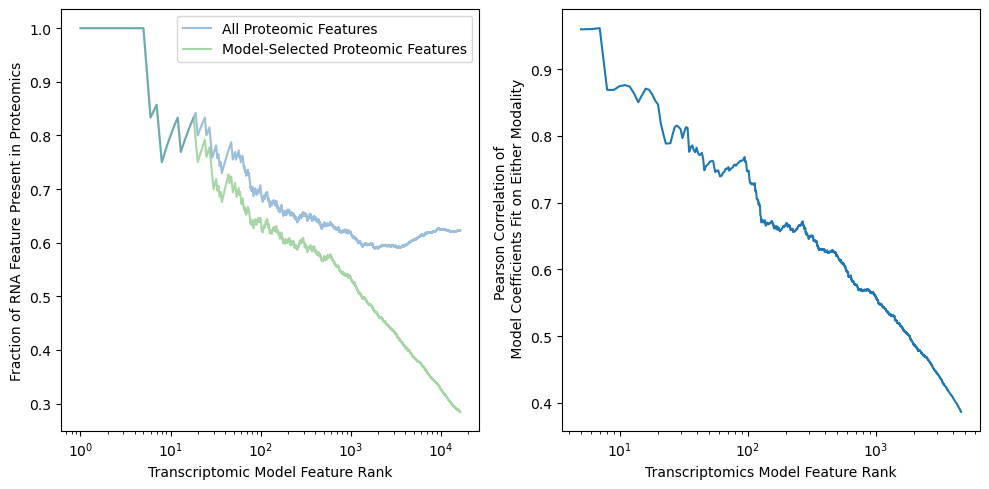

In [13]:
fig, ax = plt.subplots(figsize = (10,5), ncols = 2)


i = 0

viz_df = model_coefs_rna.copy()
viz_df['rank'] = [i +1 for i in viz_df.index.tolist()]




sns.lineplot(data = viz_df, x = 'rank', y = 'fraction_overlap_all', ax = ax[i], 
             color = sns.color_palette('Set1')[1], alpha=0.5,
             label = 'All Proteomic Features', zorder = 1,
            )
sns.lineplot(data = viz_df, x = 'rank', y = 'fraction_overlap_selected', ax = ax[i], 
             color = sns.color_palette('Set1')[2], alpha = 0.5,
             label = 'Model-Selected Proteomic Features', zorder = 0)
ax[i].set_xscale('log')
ax[i].set_xlabel('Transcriptomic Model Feature Rank')
ax[i].set_ylabel('Fraction of RNA Feature Present in Proteomics')

i = 1
rank_pearson = pd.DataFrame(rank_pearson)
sns.lineplot(data = rank_pearson, x = '{} Feature Rank'.format(modality_ranker), y = 'Pearson Correlation', ax = ax[i])
ax[i].set_xlabel('{} Model Feature Rank'.format(modality_ranker))
ax[i].set_xscale('log')
ax[i].set_ylabel('Pearson Correlation of \n Model Coefficients Fit on Either Modality')
;


fig.tight_layout()

# plt.savefig(os.path.join(data_path, 'figures', 'intersection_rank.png'), 
#             dpi=300, 
#             bbox_inches="tight")  
;

In [14]:
model_coefs_rna[model_coefs_rna['feature_rank'].isin([1, 5, 100, 500])][
    ['feature_rank', 'fraction_overlap_all', 'fraction_overlap_selected']
]

,feature_rank,fraction_overlap_all,fraction_overlap_selected
0,1,1.000,1.00
4,5,1.000,1.00
99,100,0.700,0.64
499,500,0.634,0.57


We're looking for support of the hypothesis that: transcriptomics models outperform proteomics due to higher genome-wide coverage in measurement.
    
On the left panel, we see the fraction of transcriptomic features at that rank that are present in proteomics (either all proteomics features or model-selected proteomics features). 

Considering the blue line, all proteomics features, ff our hypothesis is true, we would expect that at higher ranks, there would be fewer features present in transcriptomics than at lower ranks. Here, the overall trend indicates the opposite of our hypothesis: those features most important for the transcriptomics model are in fact present in the proteomics dataset. However, it is important to keep in mind that this can be more nuanced: for example, in the top 5-100 features, the overlap drops from 100% to 70%. It is possible that that missing 30% of features makes all the difference in model performance. 

This is supported when looking only at selected features in the proteomic model (green line) -- amongst the top 500 and even 1000 features, this overlap does not drop off steeply from all proteomic features (i.e., green line mirrors blue line). This indicates that when the same high ranking features *are* available to the proteomics model, it will use them. 

Finally, we can look specifically at how the model uses those same features. We: 

1) Subset to the overlapping selected features between the two models (taking the mean SVM coefficient) in instances of many to one mappings)
2) x-axis: Rank order by absolute value SVM coefficient of the transcriptomcis model. 
3) y-axis: At a given feature rank, calculate the Pearson correlation of the SVM coefficient 

Nearly all selected proteomics models were present in transcriptomics. This allowed us to assess similarity of model fits between the two modalities. Across all common features, atleast a moderate Pearson correlation is maintained. This further supports the notion that when a gene is measured by both assays, the proteomics and transcriptomics models agree strongly on its importance and direction.

It brings up an interesting secondary point, which is that this seems to indicate that the two modalities carry similar information on phenotype. The slight discrepancy between the green and blue line could indicate those instances where the two modalities carry distinct information. Altogether, this brings up an important question: How similar is the information on phenotype between the two modalities, and how would a model with access to both simultaneously utilize these similarities/dissimilarities? We will address this more in Notebook C. 

# 2. Intersection with Proteomic Features

Here, we re-run our prediction pipeline, starting again from hyperparameter tuning. We proceed with the linear SVRs as explained above. However, to make the comparison fair, in this case, for both transcriptomics and proteomics, we start with the intersection of features. Furthermore, we only use the samples in common between the two (similar to the power analysis).

In [15]:
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

import optuna
from optuna.samplers import CmaEsSampler, TPESampler, RandomSampler

from utils import MeanCenterer, HybridSampler, RandomTPESampler
from utils import RNAFeatureSelector, ProteinFeatureSelector

In [16]:
feature_selector_map = {'Transcriptomics': RNAFeatureSelector, 
                     'Proteomics': ProteinFeatureSelector}

## 2.0: Map samples between proteomics and transcriptomics:

In [17]:
md = pd.read_csv(os.path.join(data_path, 'raw', 'Model.csv'), index_col = 0)

expr_protein.index = pd.Series(expr_protein.index).apply(lambda x: x.split('_')[0])

sample_mapper = md[md.StrippedCellLineName.isin(expr_protein.index)]
sample_mapper = dict(zip(sample_mapper.StrippedCellLineName, sample_mapper.index))
if len(sample_mapper) != expr_protein.shape[0]:
    raise ValueError('Expect all samples to be mapped')
expr_protein.index = expr_protein.index.map(sample_mapper)
mp_protein.index = expr_protein.index

with open(os.path.join(data_path, 'processed', 'proteomics_sample_mapper.json'), "w") as json_file:
    json.dump(sample_mapper, json_file, indent=4)

In [18]:
common_samples = sorted(set(expr_protein.index).intersection(expr_rna.index))
print('Of the {} and {} samples in protein and RNA datasets, respectively, {} are shared'.format(expr_protein.shape[0], 
                                                                                                expr_rna.shape[0], 
                                                                                                len(common_samples)))

Of the 248 and 481 samples in protein and RNA datasets, respectively, 247 are shared


In [19]:
expr_protein_common = expr_protein.loc[common_samples, :]
expr_rna_common = expr_rna.loc[common_samples, :]
mp_common = mp_protein.loc[common_samples, :]

y_common = mp_common['mean'].values.ravel()

## 2.1: Hyperparameter tuning

This is conducted on all samples available to each dataset, as previously described in notebooks A/02 and B/02: 

In [20]:
intersect_genes = set(rna_names).intersection(protein_names)

rna_cols_intersect = [rna_cols[i] for i, rna_name in enumerate(rna_names) if rna_name in intersect_genes]
protein_cols_intersect = [protein_cols[i] for i, protein_name in enumerate(protein_names) if protein_name in intersect_genes]

n_protein_features = len(protein_cols_intersect) 
n_rna_features = len(rna_cols_intersect)
if n_protein_features != n_rna_features:
    msg = 'Due to a lack of 1-to-1 mapping between protein and RNA features, '
    msg += 'taking the intersection between them results in {} '.format(n_protein_features)
    msg += 'protein features and {} RNA features'.format(n_rna_features)
    print(msg)
    print('')
    
    msg = 'Compare this to the starting amount of features for each: '
    msg += ' {} and {} for protein and RNA, respectively'.format(len(protein_cols), len(rna_cols))
    print(msg)


Due to a lack of 1-to-1 mapping between protein and RNA features, taking the intersection between them results in 10560 protein features and 10202 RNA features

Compare this to the starting amount of features for each:  10969 and 16371 for protein and RNA, respectively


In [21]:
def optuna_objective(trial, X, y, inner_cv, n_cores, random_state, modality):
    model_type = 'SVR_linear'
    
    # Define feature reduction/selection method
    FeatureSelector = feature_selector_map[modality]
    steps = [
        ("feature_reduction", FeatureSelector(method="top_residuals", 
                                              n_features=trial.suggest_categorical("FeatureSelector__n_features", [250, 500, 1000, 5000, X.shape[1]]))),
        ("mean_centering", MeanCenterer()),
    ]

    steps.append(("model", SVR(
        kernel='linear',
        C=trial.suggest_float(model_type + "__C", 1e-4, 1e2, log = True),
        epsilon=trial.suggest_float(model_type + "__epsilon", 1e-3, 10, log=True)
    )))

    # Create the pipeline
    pipeline = Pipeline(steps)

    # Evaluate with cross-validation
    mse = -cross_val_score(pipeline, X, y, 
                           cv=inner_cv, 
                           scoring="neg_mean_squared_error", 
                           n_jobs=inner_cv.n_splits).mean()

    return mse

def generate_best_pipeline(study, modality):
    FeatureSelector = feature_selector_map[modality]
    best_params = study.best_params
    steps = []
    steps.append(("feature_reduction", FeatureSelector(method="top_residuals", n_features=best_params["FeatureSelector__n_features"])))
    steps.append(("mean_centering", MeanCenterer()))
    
    steps.append(("model", SVR(
        kernel='linear',
        C=best_params["SVR_linear__C"],
        epsilon=best_params['SVR_linear__epsilon']
    )))
    best_pipeline = Pipeline(steps)
    return best_pipeline



In [22]:
X_protein = expr_protein_common[protein_cols_intersect].copy().values
X_rna = expr_rna_common[rna_cols_intersect].copy().values


outer_folds=10
inner_folds=5
n_trials = 100

In [23]:
cmaes_sampler = CmaEsSampler(seed=random_state, 
                             warn_independent_sampling=False, 
                            restart_strategy='bipop')

exploration_sampler = RandomSampler(seed=random_state)
tpe_sampler = RandomTPESampler(seed=random_state, 
                               n_startup_trials = 15,
                               exploration_sampler = exploration_sampler, 
                               exploration_freq=20 # randomly sample every n trials
                              )

/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/optuna/samplers/_cmaes.py:270: FutureWarning: `restart_strategy` has been deprecated in v4.4.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v4.4.0. From v4.4.0 onward, `restart_strategy` automatically falls back to `None`. `restart_strategy` will be supported in OptunaHub.
  warnings.warn(


In [ ]:
# outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
# inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)

# results = []
# res_df = None

# for k, (train_idx, test_idx) in enumerate(outer_cv.split(X_protein, y_common)):
#     print(k)
#     y_train, y_test = y_common[train_idx], y_common[test_idx]

#     X = {'Proteomics': {}, 
#         'Transcriptomics': {}}

#     X['Proteomics']['train'], X['Proteomics']['test'] = X_protein[train_idx], X_protein[test_idx]
#     X['Transcriptomics']['train'], X['Transcriptomics']['test'] = X_rna[train_idx], X_rna[test_idx]

#     for modality in X:
#         pruner = optuna.pruners.SuccessiveHalvingPruner()
#         study = optuna.create_study(direction="minimize", 
#                                     sampler=HybridSampler(primary_sampler=cmaes_sampler, fallback_sampler=tpe_sampler), 
#                                    pruner = pruner, 
#                                    study_name = '{}_optuna'.format(k))
#         study.optimize(
#             lambda trial: optuna_objective(trial, X[modality]['train'], y_train, inner_cv, n_cores, random_state, modality),
#             n_trials=n_trials, 
#             catch=(ValueError,)
#         )
        
#         best_pipeline = generate_best_pipeline(study, modality)
#         best_pipeline.fit(X[modality]['train'], y_train)

#         y_train_pred = best_pipeline.predict(X[modality]['train'])
#         y_test_pred = best_pipeline.predict(X[modality]['test'])

#         train_corr = pearsonr(y_train, y_train_pred)[0]
#         test_corr = pearsonr(y_test, y_test_pred)[0]
#         train_mse = mean_squared_error(y_train, y_train_pred)
#         test_mse = mean_squared_error(y_test, y_test_pred)
        
#         results.append({
#             "modality": modality,
#             "fold": k,
#             "train_corr": train_corr,
#             "test_corr": test_corr,
#             "train_mse": train_mse,
#             "test_mse": test_mse,
#             "best_params": study.best_params,
#             "inner_cv": study.trials_dataframe()
#             })
#         res_df = pd.DataFrame(results)
#         res_df.to_csv(os.path.join(data_path, 'interim', 'pipeline_model_selection_featureintersect.csv'))


res_df = pd.read_csv(os.path.join(data_path, 'interim', 'pipeline_model_selection_featureintersect.csv'), 
                    index_col = 0)
res_df.modality = pd.Categorical(res_df.modality, 
                                ordered=True, 
                                categories=['Transcriptomics', 'Proteomics'])

# you are here

In [ ]:
r_res = res_df[res_df.modality == 'Transcriptomics']
p_res = res_df[res_df.modality == 'Proteomics']

In [ ]:
for x in r_res.best_params:
    print(eval(x)['FeatureSelector__n_features'])

In [ ]:
for x in p_res.best_params:
    print(eval(x)['FeatureSelector__n_features'])

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))

res_stats_all = pd.DataFrame(columns = ['comparison', 'pval', 'cohend', 'metric'])
for i, metric in enumerate(metric_types):    
    sns.violinplot(data = res_df, x = 'modality', y = 'test_' + metric, ax = ax[i])
    
    pval = stats.mannwhitneyu(r_res['test_' + metric], p_res['test_' + metric]).pvalue
    cd = cohen_d(r_res['test_' + metric], p_res['test_' + metric])
    res_stats_all.loc[i, :] = [('Linear SVR - Transcriptomics', 'Linear SVR'), pval, cd, mmap[metric]]
    
    ax[i].annotate("MWU p-val: {:.3f}".format(pval), xy=(0.35, 0.95), xycoords='axes fraction')
    ax[i].annotate("Cohen's D: {:.2f}".format(cd), xy=(0.35, 0.9), xycoords='axes fraction')
    
    ax[i].set_xlabel('Modality')
    ax[i].set_ylabel(mmap[metric])
    
res_stats_all.to_csv(os.path.join(data_path, 'interim', 'proteomics_consensus_comparison_intersection.csv'))
fig.suptitle('Intersection of Features')

plt.savefig(os.path.join(data_path, 'figures', 'intersection_intersectioncomparison.png'), 
            dpi=300, 
            bbox_inches="tight")  

fig.tight_layout()
;

Let's ensure that, in contrast, on these 10-folds but each data modality using all features, the power analysis results demonstrating transcriptomics outperforms proteomics holds:

In [ ]:
best_pipeline_rna = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline_protein = read_pickled_object(os.path.join(data_path, 'processed', 'best_model_proteomics_svrlinear.pickle'))

X_rna = expr_rna_common.values
X_protein = expr_protein_common.values

In [ ]:
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
results = []
res_df = None


for k, (train_idx, test_idx) in enumerate(outer_cv.split(X_protein, y_common)):
    y_train, y_test = y_common[train_idx], y_common[test_idx]

    X = {'Proteomics': {}, 
        'Transcriptomics': {}}

    X['Proteomics']['train'], X['Proteomics']['test'] = X_protein[train_idx], X_protein[test_idx]
    X['Transcriptomics']['train'], X['Transcriptomics']['test'] = X_rna[train_idx], X_rna[test_idx]
    
    for modality, best_pipeline in best_pipeline_modality.items():
        best_pipeline.fit(X[modality]['train'], y_train)

        y_train_pred = best_pipeline.predict(X[modality]['train'])
        y_test_pred = best_pipeline.predict(X[modality]['test'])

        train_corr = pearsonr(y_train, y_train_pred)[0]
        test_corr = pearsonr(y_test, y_test_pred)[0]
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        results.append({
            "modality": modality,
            "fold": k,
            "train_corr": train_corr,
            "test_corr": test_corr,
            "train_mse": train_mse,
            "test_mse": test_mse,
            })
        res_df = pd.DataFrame(results)
        
res_df.modality = pd.Categorical(res_df.modality, 
                                ordered=True, 
                                categories=['Transcriptomics', 'Proteomics'])

In [ ]:
r_res = res_df[res_df.modality == 'Transcriptomics']
p_res = res_df[res_df.modality == 'Proteomics']

In [ ]:
r_res.test_corr.std()

In [ ]:
p_res.test_corr.std()

In [ ]:
r_res.test_mse.std()

In [ ]:
p_res.test_mse.std()

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))


for i, metric in enumerate(metric_types):    
    sns.violinplot(data = res_df, x = 'modality', y = 'test_' + metric, ax = ax[i])
    
    pval = stats.mannwhitneyu(r_res['test_' + metric], p_res['test_' + metric]).pvalue
    cd = cohen_d(r_res['test_' + metric], p_res['test_' + metric])
    
    ax[i].annotate("MWU p-val: {:.3f}".format(pval), xy=(0.35, 0.95), xycoords='axes fraction')
    ax[i].annotate("Cohen's D: {:.2f}".format(cd), xy=(0.35, 0.9), xycoords='axes fraction')
    
    ax[i].set_xlabel('Modality')
    ax[i].set_ylabel(mmap[metric])
    
fig.suptitle('All Features')
plt.savefig(os.path.join(data_path, 'figures', 'intersection_unionncomparison.png'), 
            dpi=300, 
            bbox_inches="tight")  
fig.tight_layout()

## 2.2 Top Features Comparison

Let's also compare the extent to which top-ranked features agree when we use just the intersection of features.

In [ ]:
res_df = pd.read_csv(os.path.join(data_path, 'interim', 'pipeline_model_selection_featureintersect.csv'), 
                    index_col = 0)
res_df.modality = pd.Categorical(res_df.modality, 
                                ordered=True, 
                                categories=['Transcriptomics', 'Proteomics'])

r_res = res_df[res_df.modality == 'Transcriptomics']
p_res = res_df[res_df.modality == 'Proteomics']

X_protein = expr_protein_common[protein_cols_intersect].copy().values
X_rna = expr_rna_common[rna_cols_intersect].copy().values

In [ ]:
n_features_best = []
C_best = []
epsilon_best = []
for bp in r_res.best_params:
    print(bp)
    print('------------------------------------------------------')
    bp = eval(bp)
    n_features_best.append(bp['FeatureSelector__n_features'])
    C_best.append(bp['SVR_linear__C'])
    epsilon_best.append(bp['SVR_linear__epsilon'])
    
    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = sorted(pd.Series(n_features_best).mode())[0])),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best)
#     random_state=random_state,
#     n_jobs=n_cores
)))

best_intersection_pipeline_rna = Pipeline(best_steps)
best_intersection_pipeline_rna

In [ ]:
n_features_best = []
C_best = []
epsilon_best = []
for bp in p_res.best_params:
    print(bp)
    print('------------------------------------------------------')
    bp = eval(bp)
    n_features_best.append(bp['FeatureSelector__n_features'])
    C_best.append(bp['SVR_linear__C'])
    epsilon_best.append(bp['SVR_linear__epsilon'])
    
    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = sorted(pd.Series(n_features_best).mode())[0])),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best)
#     random_state=random_state,
#     n_jobs=n_cores
)))

best_intersection_pipeline_protein = Pipeline(best_steps)
best_intersection_pipeline_protein

In [ ]:
best_intersection_pipeline_protein.fit(X_protein, y_common)
best_intersection_pipeline_rna.fit(X_rna, y_common)

In [ ]:
model_coefs_protein = get_ranked_coefs(best_intersection_pipeline_protein, protein_map, protein_cols)
model_coefs_rna = get_ranked_coefs(best_intersection_pipeline_rna, rna_map, rna_cols)

In [ ]:
model_coefs_protein.Gene_Name.tolist() + 

In [ ]:
[total_features - model_coefs_protein.shape[0]

In [ ]:
i = 3000

In [ ]:
total_features = max(model_coefs_protein.shape[0], model_coefs_rna.shape[0])
viz_df = pd.DataFrame(data = {
    'Rank': list(range(1, total_features + 1)), 
    'RNA': model_coefs_rna.Gene_Name.tolist() + [np.nan]*(total_features - model_coefs_rna.shape[0]), 
    'Protein': model_coefs_protein.Gene_Name.tolist() + [np.nan]*(total_features - model_coefs_protein.shape[0])
})

fraction_overlap = []
for i in tqdm(viz_df.index):
    proteins = set(viz_df.loc[:i, 'Protein'][viz_df.loc[:i, 'Protein'].notna()])
    rnas = set(viz_df.loc[:i, 'RNA'][viz_df.loc[:i, 'RNA'].notna()])
    
    fraction_overlap.append(float(len(set(proteins).intersection(rnas))/viz_df.loc[i, 'Rank']))
viz_df['fraction_overlap'] = fraction_overlap

In [ ]:
sns.lineplot(data = viz_df, x = 'Rank', y = 'fraction_overlap')